In [18]:
import xgbFunc
import xgboost as xgb
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap
import importlib
importlib.reload(xgbFunc)

<module 'xgbFunc' from '/home/flyingbucket/CODE/NewZealand_traffic/xgbFunc.py'>

In [2]:
# from xgboost import XGBClassifier
# clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
# print(clf)
# from xgboost import Booster
# print(Booster({'tree_method': 'gpu_hist'}).attributes())


In [3]:
# import numpy as np
# from xgboost import XGBClassifier

# X = np.random.rand(100, 10)
# y = np.random.randint(0, 2, size=100)

# model = XGBClassifier(tree_method='hist', device='gpu')
# model.fit(X, y)


In [4]:
data_ori=pd.read_csv("data/crash.csv")
y = data_ori["crashSeverity"]
data=xgbFunc.encode_features(data_ori.drop(columns=["crashSeverity"]))
data.head()

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,2037728.0,5709220.0,1,NaN,544500.0,1.0,NaN,0.0,1.0,NaN,...,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN,3.0,1.0
1,1793829.0,5500169.0,2,NaN,564231.0,0.0,NaN,0.0,1.0,NaN,...,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0
2,1753976.0,5929363.0,3,NaN,508420.0,0.0,NaN,0.0,2.0,NaN,...,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0
3,1771836.0,5914911.0,4,NaN,521602.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0
4,1752438.0,5918349.0,5,NaN,515002.0,0.0,NaN,0.0,2.0,NaN,...,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0


In [5]:
data.columns

Index(['X', 'Y', 'OBJECTID', 'advisorySpeed', 'areaUnitID', 'bicycle',
       'bridge', 'bus', 'carStationWagon', 'cliffBank',
       'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1',
       'crashLocation2', 'crashRoadSideRoad', 'crashSHDescription',
       'crashYear', 'debris', 'directionRoleDescription', 'ditch',
       'fatalCount', 'fence', 'flatHill', 'guardRail', 'holiday',
       'houseOrBuilding', 'intersection', 'kerb', 'light', 'meshblockId',
       'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
       'objectThrownOrDropped', 'otherObject', 'otherVehicleType', 'overBank',
       'parkedVehicle', 'pedestrian', 'phoneBoxEtc', 'postOrPole', 'region',
       'roadCharacter', 'roadLane', 'roadSurface', 'roadworks', 'schoolBus',
       'seriousInjuryCount', 'slipOrFlood', 'speedLimit', 'strayAnimal',
       'streetLight', 'suv', 'taxi', 'temporarySpeedLimit', 'tlaId', 'tlaName',
       'trafficControl', 'trafficIsland', 'trafficSign', 'train', 'tr

In [6]:
le_y=LabelEncoder()
y=le_y.fit_transform(y)
X_train, X_test, y_train, y_test=train_test_split(data,y, test_size=0.2, random_state=42)


In [21]:
best_params,best_score,label_encoder,num_classes=xgbFunc.xgb_clf_search_gpu(X_train,y_train,n_iter=100)

Starting random search...


100%|██████████| 100/100 [27:56<00:00, 16.77s/it]


Best Parameters:
learning_rate: 0.12236203565420874
max_depth: 7
min_child_weight: 8
gamma: 0.2993292420985183
subsample: 0.7468055921327309
colsample_bytree: 0.7467983561008608
reg_alpha: 0.05808361216819946
reg_lambda: 0.8661761457749352
n_estimators: 199
Best Accuracy: 0.9999698236035665


In [22]:
model = XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    n_jobs=-1,
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',     
    device='cuda',         
)
model.set_params(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


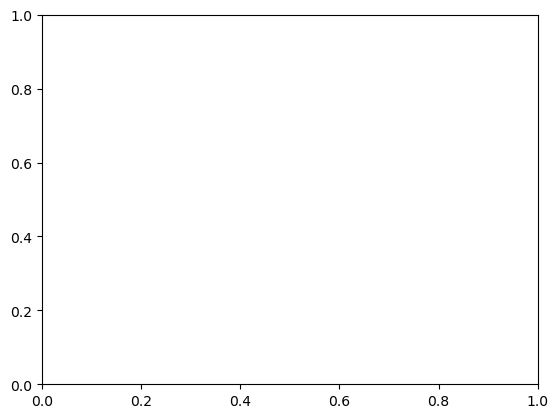

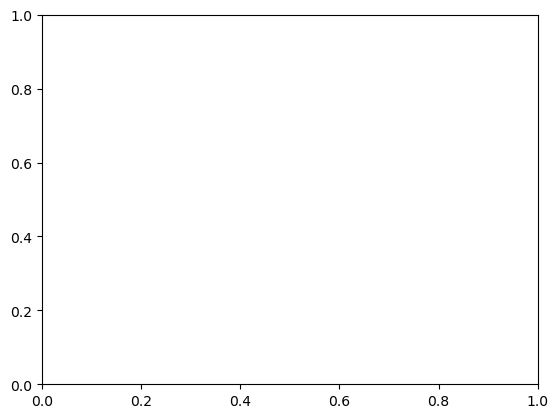

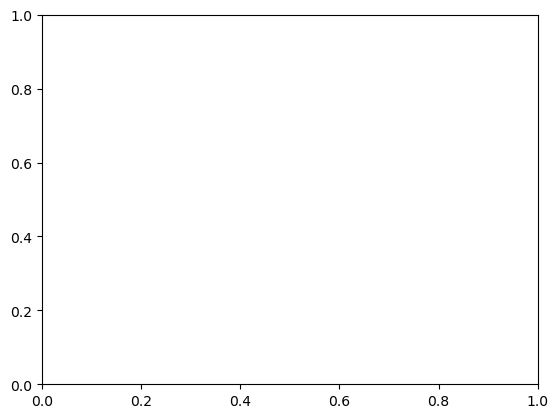

In [23]:
import os
if not os.path.exists("result"):
    os.makedirs("result")
result_path="result"
importance_figs=xgbFunc.visualize_importance(model)
for fig,imp_type in importance_figs:
    fig.savefig(os.path.join(result_path,f"{imp_type}.png"), dpi=300)

In [26]:
model.save_model(os.path.join(result_path,"model_ori.json"))

In [25]:
shap_fig=xgbFunc.visulize_shap(model, X_train)
shap_fig.savefig(os.path.join(result_path,"shap.png"), dpi=300)

C extension was not built during install!


ImportError: numpy.core.multiarray failed to import